In [1]:
import os, joblib, numpy as np, pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             roc_auc_score, RocCurveDisplay, ConfusionMatrixDisplay)
from sklearn.linear_model import LogisticRegression

# Garantir existência das pastas
os.makedirs("../figures", exist_ok=True)
os.makedirs("../models", exist_ok=True)

# Estilo dos gráficos
sns.set()
pd.set_option("display.float_format", lambda x: f"{x:,.4f}")


In [2]:
from textwrap import dedent
print(dedent("""
PROBLEMA (Classificação): Identificar se um tumor é maligno (1) ou benigno (0),
usando variáveis numéricas do dataset Breast Cancer Wisconsin.

O modelo escolhido foi a Regressão Logística, adequada para problemas de classificação binária.

Serão calculadas as métricas:
- Acurácia
- Precisão
- Revocação (Recall)
- F1-Score
- AUC-ROC

Também será exibida:
- Matriz de confusão
- Curva ROC
"""))



PROBLEMA (Classificação): Identificar se um tumor é maligno (1) ou benigno (0),
usando variáveis numéricas do dataset Breast Cancer Wisconsin.

O modelo escolhido foi a Regressão Logística, adequada para problemas de classificação binária.

Serão calculadas as métricas:
- Acurácia
- Precisão
- Revocação (Recall)
- F1-Score
- AUC-ROC

Também será exibida:
- Matriz de confusão
- Curva ROC



In [3]:
data = load_breast_cancer(as_frame=True)
df = data.frame.copy()
df["target"] = data.target
df.head()


,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.9900,10.3800,122.8000,"1,001.0000",0.1184,0.2776,0.3001,0.1471,0.2419,0.0787,...,17.3300,184.6000,"2,019.0000",0.1622,0.6656,0.7119,0.2654,0.4601,0.1189,0
1,20.5700,17.7700,132.9000,"1,326.0000",0.0847,0.0786,0.0869,0.0702,0.1812,0.0567,...,23.4100,158.8000,"1,956.0000",0.1238,0.1866,0.2416,0.1860,0.2750,0.0890,0
2,19.6900,21.2500,130.0000,"1,203.0000",0.1096,0.1599,0.1974,0.1279,0.2069,0.0600,...,25.5300,152.5000,"1,709.0000",0.1444,0.4245,0.4504,0.2430,0.3613,0.0876,0
3,11.4200,20.3800,77.5800,386.1000,0.1425,0.2839,0.2414,0.1052,0.2597,0.0974,...,26.5000,98.8700,567.7000,0.2098,0.8663,0.6869,0.2575,0.6638,0.1730,0
4,20.2900,14.3400,135.1000,"1,297.0000",0.1003,0.1328,0.1980,0.1043,0.1809,0.0588,...,16.6700,152.2000,"1,575.0000",0.1374,0.2050,0.4000,0.1625,0.2364,0.0768,0


In [4]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   mean radius              569 non-null    float64
 1   mean texture             569 non-null    float64
 2   mean perimeter           569 non-null    float64
 3   mean area                569 non-null    float64
 4   mean smoothness          569 non-null    float64
 5   mean compactness         569 non-null    float64
 6   mean concavity           569 non-null    float64
 7   mean concave points      569 non-null    float64
 8   mean symmetry            569 non-null    float64
 9   mean fractal dimension   569 non-null    float64
 10  radius error             569 non-null    float64
 11  texture error            569 non-null    float64
 12  perimeter error          569 non-null    float64
 13  area error               569 non-null    float64
 14  smoothness error         5

In [5]:
df.describe().T


,count,mean,std,min,25%,50%,75%,max
mean radius,569.0000,14.1273,3.5240,6.9810,11.7000,13.3700,15.7800,28.1100
mean texture,569.0000,19.2896,4.3010,9.7100,16.1700,18.8400,21.8000,39.2800
mean perimeter,569.0000,91.9690,24.2990,43.7900,75.1700,86.2400,104.1000,188.5000
mean area,569.0000,654.8891,351.9141,143.5000,420.3000,551.1000,782.7000,"2,501.0000"
mean smoothness,569.0000,0.0964,0.0141,0.0526,0.0864,0.0959,0.1053,0.1634
mean compactness,569.0000,0.1043,0.0528,0.0194,0.0649,0.0926,0.1304,0.3454
mean concavity,569.0000,0.0888,0.0797,0.0000,0.0296,0.0615,0.1307,0.4268
mean concave points,569.0000,0.0489,0.0388,0.0000,0.0203,0.0335,0.0740,0.2012
mean symmetry,569.0000,0.1812,0.0274,0.1060,0.1619,0.1792,0.1957,0.3040
mean fractal dimension,569.0000,0.0628,0.0071,0.0500,0.0577,0.0615,0.0661,0.0974


In [6]:
df["target"].value_counts(normalize=True)


target
1   0.6274
0   0.3726
Name: proportion, dtype: float64

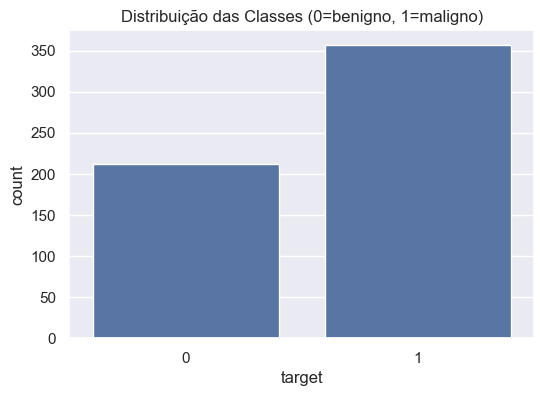

In [7]:
plt.figure(figsize=(6,4))
sns.countplot(x="target", data=df)
plt.title("Distribuição das Classes (0=benigno, 1=maligno)")
plt.savefig("../figures/cancer_classes.png", dpi=120, bbox_inches="tight")
plt.show()


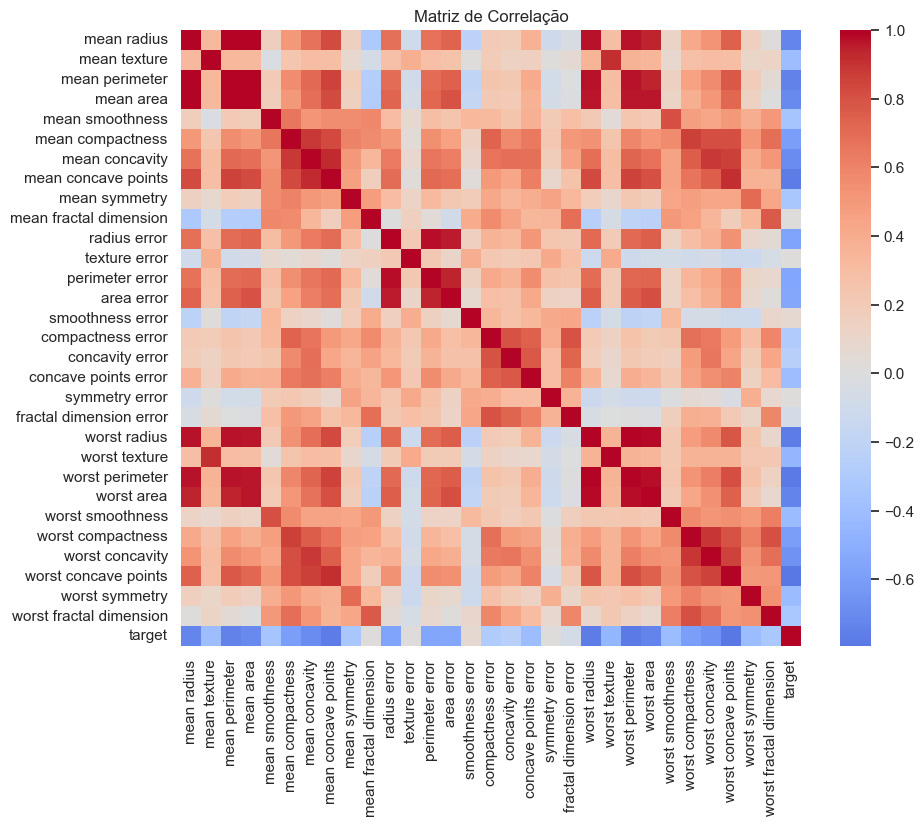

In [8]:
corr = df.corr(numeric_only=True)
plt.figure(figsize=(10,8))
sns.heatmap(corr, cmap="coolwarm", center=0)
plt.title("Matriz de Correlação")
plt.savefig("../figures/cancer_corr.png", dpi=120, bbox_inches="tight")
plt.show()


In [9]:
X = df.drop(columns=["target"])
y = df["target"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

pipeline = Pipeline(steps=[
    ("scaler", StandardScaler()),
    ("logreg", LogisticRegression(max_iter=500, solver="lbfgs"))
])

pipeline.fit(X_train, y_train)


,steps,"[('scaler', ...), ('logreg', ...)]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True
,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0


In [10]:
y_pred = pipeline.predict(X_test)
y_proba = pipeline.predict_proba(X_test)[:,1]

acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_proba)

print(f"Acurácia:   {acc:.3f}")
print(f"Precisão:   {prec:.3f}")
print(f"Revocação:  {rec:.3f}")
print(f"F1-Score:   {f1:.3f}")
print(f"AUC-ROC:    {auc:.3f}")


Acurácia:   0.982
Precisão:   0.986
Revocação:  0.986
F1-Score:   0.986
AUC-ROC:    0.995


In [11]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_auc = cross_val_score(pipeline, X, y, cv=cv, scoring="roc_auc")

print("AUC-ROC CV (média ± desvio):", f"{cv_auc.mean():.3f} ± {cv_auc.std():.3f}")


AUC-ROC CV (média ± desvio): 0.995 ± 0.005


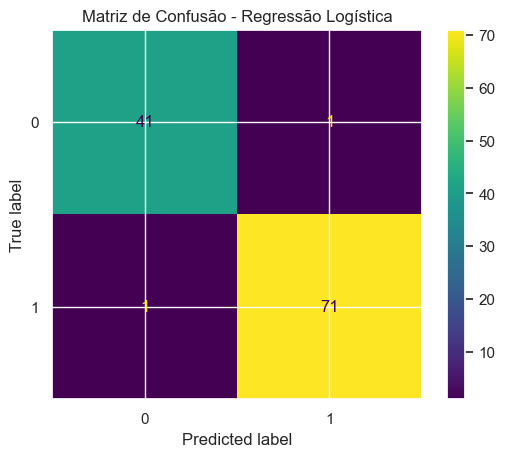

In [12]:
ConfusionMatrixDisplay.from_estimator(pipeline, X_test, y_test)
plt.title("Matriz de Confusão - Regressão Logística")
plt.savefig("../figures/log_confusion_matrix.png", dpi=120, bbox_inches="tight")
plt.show()


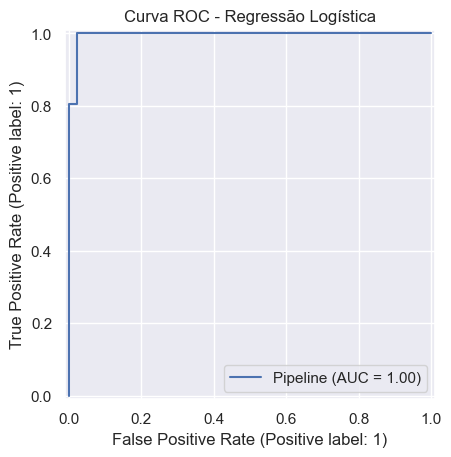

In [13]:
RocCurveDisplay.from_estimator(pipeline, X_test, y_test)
plt.title("Curva ROC - Regressão Logística")
plt.savefig("../figures/log_roc.png", dpi=120, bbox_inches="tight")
plt.show()


In [14]:
joblib.dump(pipeline, "../models/logistica_cancer_mama.pkl")
print("Modelo salvo em ../models/logistica_cancer_mama.pkl")


Modelo salvo em ../models/logistica_cancer_mama.pkl


### Análise dos Resultados – Regressão Logística (Breast Cancer Wisconsin)

O objetivo deste experimento foi construir um modelo de **classificação binária** capaz de identificar se um tumor é **maligno** (1) ou **benigno** (0), utilizando o dataset *Breast Cancer Wisconsin*, disponibilizado pela biblioteca `sklearn.datasets`. Todos os atributos do conjunto de dados são numéricos e descrevem características morfológicas de imagens obtidas por mamografia.

Foi utilizada a **Regressão Logística**, um modelo eficiente e interpretável para problemas de classificação binária. O pipeline incluiu uma etapa de **padronização** (`StandardScaler`) seguida da aplicação do classificador.

Nos dados de teste, o modelo apresentou:

- **Acurácia:** 0.982  
- **Precisão:** 0.986  
- **Revocação (Recall):** 0.986  
- **F1-Score:** 0.986  
- **AUC-ROC:** 0.995  

Esses resultados mostram que o modelo possui desempenho **excelente**, com baixa taxa de falsos positivos e falsos negativos. A alta precisão indica que, quando o modelo classifica um tumor como maligno, ele acerta em 98,6% dos casos. A revocação igualmente alta indica que o modelo consegue recuperar quase todos os casos de tumores malignos, o que é essencial para aplicações da área da saúde.

Para validar a estabilidade do modelo, foi realizada uma **validação cruzada estratificada** com 5 folds, resultando em:

- **AUC-ROC médio:** 0.995  
- **Desvio padrão:** 0.005  

Esse resultado confirma que o modelo generaliza bem e mantém desempenho consistente, com variações mínimas entre as diferentes partições dos dados.

Os gráficos gerados reforçam esses achados:

- A **matriz de confusão** exibiu pouquíssimos erros de classificação.
- A **curva ROC** apresentou área sob a curva próxima de 1.0, evidenciando excelente separação entre as classes.

Dada a natureza do problema e os resultados obtidos, conclui-se que a Regressão Logística é uma abordagem altamente adequada para este dataset, oferecendo precisão, estabilidade e interpretabilidade para a tarefa de diagnóstico automático. O pipeline completo foi salvo no arquivo `logistica_cancer_mama.pkl` para uso futuro sem necessidade de retreino.
